## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, models, transforms

from skimage.transform import resize
from skimage.io import imread

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn

from pytorch_grad_cam import CAM
from pytorch_grad_cam.utils.image import show_cam_on_image

import os

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## Dataset

In [22]:
dir_path = 'Peliculas_Manu_Select/'
train_dir = 'train_set/'
valid_dir = 'valid_set/'
test_dir = 'test_set/'

In [23]:
def get_dataframe(path, subdir):
    videos = []
    labels = []
    path = path + subdir
    for folder in os.listdir(path):
        # print(folder)
        fd = path + folder + '/'
        # print(fd)
        for video in os.listdir(fd):
            vd = os.path.join(fd, video)
            # print(vd)
            i = 1 if folder == 'fights' else 0
            videos.append(vd)
            labels.append(i)
    data_dict = {
        'videos': videos,
        'labels': labels 
    }
    dataframe = pd.DataFrame(data=data_dict)
    return dataframe

In [21]:
df_train = get_dataframe(dir_path, train_dir)
df_train

,videos,labels
0,Peliculas_Manu_Select/train_set/fights/newfi1.avi,1
1,Peliculas_Manu_Select/train_set/fights/newfi10...,1
2,Peliculas_Manu_Select/train_set/fights/newfi11...,1
3,Peliculas_Manu_Select/train_set/fights/newfi12...,1
4,Peliculas_Manu_Select/train_set/fights/newfi13...,1
...,...,...
135,Peliculas_Manu_Select/train_set/no_fights/90.mpg,0
136,Peliculas_Manu_Select/train_set/no_fights/91.mpg,0
137,Peliculas_Manu_Select/train_set/no_fights/92.mpg,0
138,Peliculas_Manu_Select/train_set/no_fights/93.mpg,0


In [24]:
df_valid = get_dataframe(dir_path, valid_dir)
df_valid

,videos,labels
0,Peliculas_Manu_Select/valid_set/fights/newfi10...,1
1,Peliculas_Manu_Select/valid_set/fights/newfi46...,1
2,Peliculas_Manu_Select/valid_set/fights/newfi47...,1
3,Peliculas_Manu_Select/valid_set/fights/newfi48...,1
4,Peliculas_Manu_Select/valid_set/fights/newfi49...,1
5,Peliculas_Manu_Select/valid_set/fights/newfi51...,1
6,Peliculas_Manu_Select/valid_set/fights/newfi52...,1
7,Peliculas_Manu_Select/valid_set/fights/newfi53...,1
8,Peliculas_Manu_Select/valid_set/fights/newfi54...,1
9,Peliculas_Manu_Select/valid_set/fights/newfi55...,1


In [25]:
df_test = get_dataframe(dir_path, test_dir)
df_test

,videos,labels
0,Peliculas_Manu_Select/test_set/fights/newfi83.avi,1
1,Peliculas_Manu_Select/test_set/fights/newfi84.avi,1
2,Peliculas_Manu_Select/test_set/fights/newfi85.avi,1
3,Peliculas_Manu_Select/test_set/fights/newfi86.avi,1
4,Peliculas_Manu_Select/test_set/fights/newfi87.avi,1
5,Peliculas_Manu_Select/test_set/fights/newfi88.avi,1
6,Peliculas_Manu_Select/test_set/fights/newfi89.avi,1
7,Peliculas_Manu_Select/test_set/fights/newfi90.avi,1
8,Peliculas_Manu_Select/test_set/fights/newfi91.avi,1
9,Peliculas_Manu_Select/test_set/fights/newfi92.avi,1


In [26]:
def capture(filename, timesep, rgb, h, w):
    tmp = []
    frames = np.zeros((timesep, rgb, h, w), dtype=float)
    i=0
    vc = cv2.VideoCapture(filename)
    if vc.isOpened():
        rval , frame = vc.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    else:
        rval = False
    frm = resize(frame, (h, w, rgb)) 
    frm = np.expand_dims(frm, axis=0)
    frm = np.moveaxis(frm, -1, 1)
    if(np.max(frm) > 1):
        frm = frm / 255.0
    frames[i][:] = frm
    i += 1
    while i < timesep:
        tmp[:] = frm[:]
        rval, frame = vc.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frm = resize(frame,( h, w, rgb))
        frm = np.expand_dims(frm, axis=0)
        if(np.max(frm) > 1):
            frm = frm / 255.0
        frm = np.moveaxis(frm, -1, 1)
        frames[i-1][:] = frm
        i +=1
    return frames.astype(np.float32)

In [32]:
idx = 139
vid = capture(df_train.iloc[idx, 0], 1, 3, 160, 160)
frame = vid[0].transpose(1, 2, 0)
print(vid.shape, vid.max(), vid.min())

(1, 3, 160, 160) 1.0 0.0


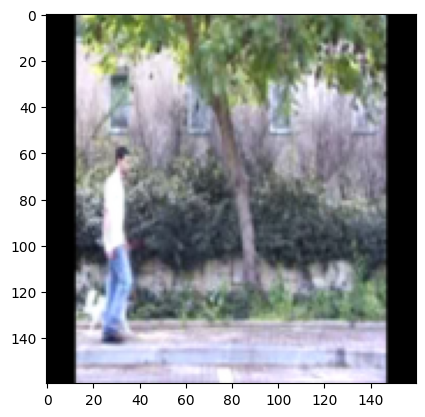

In [33]:
plt.imshow(frame)
plt.show()

In [34]:
from torch.utils.data import Dataset 

class VideoDataset(Dataset):

    def __init__(self, datas, timesep=40, rgb=3, h=160, w=160):
        self.dataloctions = datas
        self.timesep, self.rgb, self.h, self.w = timesep, rgb, h, w

    def __len__(self):
        return len(self.dataloctions)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        video = capture(self.dataloctions.iloc[idx, 0], self.timesep, self.rgb, self.h, self.w)
        sample = {'video': torch.from_numpy(video), 'label': torch.from_numpy(np.asarray(np.float32(self.dataloctions.iloc[idx, 1])))}
        return sample

In [37]:
train_set = VideoDataset(df_train)
val_set = VideoDataset(df_valid)
test_set = VideoDataset(df_test)
len(train_set), len(val_set), len(test_set)

(140, 30, 30)

In [ ]:
trainloader = torch.utils.data.DataLoader(train_set, batch_size = 3, shuffle = True)
validloader = torch.utils.data.DataLoader(val_set, batch_size = 3, shuffle = True)
testloader = torch.utils.data.DataLoader(test_set, batch_size = 1, shuffle = True)

In [40]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))
print("Total no. batches in trainloader : {}".format(len(testloader)))

Total no. batches in trainloader : 47
Total no. batches in validloader : 10
Total no. batches in trainloader : 30


## Create model

In [41]:
class TimeWarp(nn.Module):
    def __init__(self, baseModel, method='squeeze'):
        super(TimeWarp, self).__init__()
        self.baseModel = baseModel
        self.method = method
 
    def forward(self, x):
        batch_size, time_steps, C, H, W = x.size()
        if self.method == 'loop':
            output = []
            for i in range(time_steps):
                x_t = self.baseModel(x[:, i, :, :, :])
                x_t = x_t.view(x_t.size(0), -1)
                output.append(x_t)
            x = torch.stack(output, dim=0).transpose_(0, 1)
            output = None
            x_t = None 
        else:
            x = x.contiguous().view(batch_size * time_steps, C, H, W)
            x = self.baseModel(x)
            x = x.view(x.size(0), -1)
            x = x.contiguous().view(batch_size , time_steps , x.size(-1))
        return x

In [42]:
class extractlastcell(nn.Module):
    def forward(self,x):
        out , _ = x
        return out[:, -1, :]

In [ ]:
# Create model
num_features = 12800
rnn_hidden_size = 30
rnn_num_layers = 2
dr_rate= 0.2
num_classes = 1

ResNet50 = models.resnet50(pretrained=True)
custom_RN50 = nn.Sequential()
ct = 0
for child in ResNet50.children():
    if ct < 5:
        custom_RN50.append(child)
        for param in child.parameters():
            param.requires_grad = False
    elif ct == 5:
        custom_RN50.append(child)
        for param in child.parameters():
            param.requires_grad = True
    else:
        break
    ct += 1
custom_RN50.append(nn.AdaptiveAvgPool2d(output_size=(5, 5)))

model = nn.Sequential(
        TimeWarp(custom_RN50),
        nn.Dropout(dr_rate),
        nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers , batch_first=True),
        extractlastcell(),
        nn.Linear(30, 256),
        nn.ReLU(),
        nn.Dropout(dr_rate),
        nn.Linear(256, num_classes)
    )
#checkpoint = torch.load('custom/best_model_custom_B.pth')
#model.load_state_dict(checkpoint['state_dict'])

In [44]:
model.to(device)
model, device

(Sequential(
   (0): TimeWarp(
     (baseModel): Sequential(
       (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
       (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): ReLU(inplace=True)
       (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
       (4): Sequential(
         (0): Bottleneck(
           (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
           (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
           (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
           (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
           (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
           (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
           (relu): ReLU(inplace=

In [45]:
random_img = torch.rand(3, 40, 3, 160, 160).to(device)
model(random_img).shape

torch.Size([3, 1])

In [46]:
class EarlyStopping():
    def __init__(self, tolerance=2, min_delta=0.09):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            print(self.counter)
            if self.counter >= self.tolerance:  
                self.early_stop = True

## Training

In [47]:
def fit(model, trainloader, validloader, epochs=10):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    criterion = torch.nn.BCEWithLogitsLoss()

    best_valid_loss = np.Inf
    early_stopping = EarlyStopping(tolerance=3, min_delta=0.09)

    train_loss_means, train_acc_means = [], []
    val_loss_means, val_acc_means = [], []
    epoch_arr = []

    for epoch in range(1, epochs+1):
        epoch_arr.append(epoch)
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(trainloader)
        for batch in bar:
            X, y = batch['video'], batch['label']
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X).squeeze(1)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            mean_tl = np.mean(train_loss)

            y_hat = y_hat > 0.5
            co_num = (y == y_hat)
            acc = co_num.sum().item() / len(y)
            # print(y_hat, y, co_num, acc)

            train_acc.append(acc)
            mean_ta = np.mean(train_acc)
            bar.set_description(f"loss {mean_tl:.5f} acc {mean_ta:.5f}")
        train_loss_means.append(mean_tl)
        train_acc_means.append(mean_ta)

        bar = tqdm(validloader)
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch['video'], batch['label']
                X, y = X.to(device), y.to(device)
                y_hat = model(X).squeeze(1)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                mean_vl = np.mean(val_loss)
                
                y_hat = y_hat > 0.5
                co_num = (y == y_hat)
                acc = co_num.sum().item() / len(y)
                # print(y_hat, y, co_num, acc)

                val_acc.append(acc)
                mean_va = np.mean(val_acc)
                bar.set_description(f"val_loss {mean_vl:.5f} val_acc {mean_va:.5f}")
            val_loss_means.append(mean_vl)
            val_acc_means.append(mean_va)

        # best valid loss
        if mean_vl < best_valid_loss:
            torch.save(model.state_dict(), 'best_model_custom.pth')
            print("WEIGHTS-ARE-SAVED")
            best_valid_loss = mean_vl
        # early stopping
        early_stopping(mean_tl, mean_vl)
        if early_stopping.early_stop:
            print("We are at epoch:", epoch)
            break
        print(f"Epoch {epoch}/{epochs} loss {mean_tl:.5f} val_loss {mean_vl:.5f} acc {mean_ta:.5f} val_acc {mean_va:.5f}")
    return train_loss_means, train_acc_means, val_loss_means, val_acc_means, epoch_arr

In [48]:
fit_func = fit(model, trainloader, validloader)

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch 1/10 loss 0.56231 val_loss 0.58774 acc 0.66667 val_acc 0.56667


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch 2/10 loss 0.19376 val_loss 0.25186 acc 0.96454 val_acc 0.93333


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch 3/10 loss 0.03170 val_loss 0.08468 acc 0.99291 val_acc 0.96667


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

1
Epoch 4/10 loss 0.00972 val_loss 0.17719 acc 1.00000 val_acc 0.96667


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

2
Epoch 5/10 loss 0.00413 val_loss 0.17233 acc 1.00000 val_acc 0.96667


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

3
We are at epoch: 6


## Plotting Results

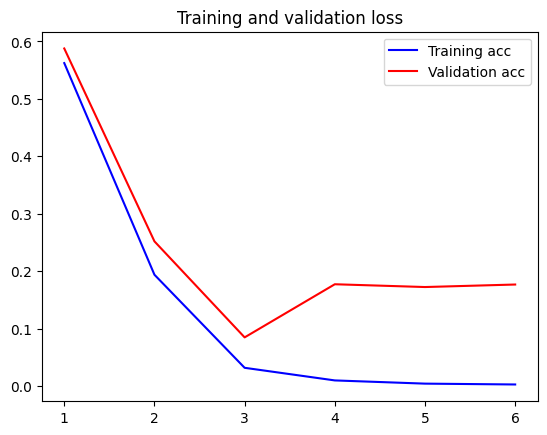

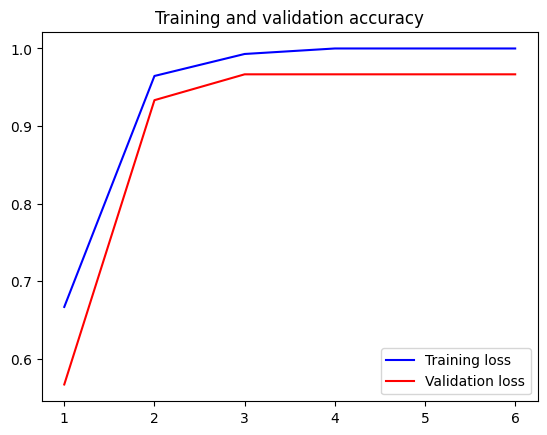

In [49]:
train_loss_means, train_acc_means, val_loss_means, val_acc_means, epochs = fit_func

plt.plot(epochs, train_loss_means, 'b', label='Training acc')
plt.plot(epochs, val_loss_means, 'r', label='Validation acc')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, train_acc_means, 'b', label='Training loss')
plt.plot(epochs, val_acc_means, 'r', label='Validation loss')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.show()

## Load Model

In [23]:
checkpoint = torch.load('weights/best_model_custom.pth')
model.load_state_dict(checkpoint)

<All keys matched successfully>

## Predicts

In [50]:
model.eval()
vid_preds, lbs = [], []
with torch.no_grad():
    for batch in testloader:
        vid, lab = batch['video'], batch['label']
        vid, lab = vid.to(device), lab.to(device)
        vid_hat = model(vid).squeeze(1)
        vid_hat = torch.sigmoid(vid_hat)
        vid_preds.append(vid_hat.item())
        lbs.append(int(lab))
        print(f"Valor predicho: {vid_hat.item():.5f} Valor real: {lab.item():.5f}")

Valor predicho: 0.99763 Valor real: 1.00000
Valor predicho: 0.99758 Valor real: 1.00000
Valor predicho: 0.99751 Valor real: 1.00000
Valor predicho: 0.99752 Valor real: 1.00000
Valor predicho: 0.99751 Valor real: 1.00000
Valor predicho: 0.99757 Valor real: 1.00000
Valor predicho: 0.99763 Valor real: 1.00000
Valor predicho: 0.99761 Valor real: 1.00000
Valor predicho: 0.99755 Valor real: 1.00000
Valor predicho: 0.99762 Valor real: 1.00000
Valor predicho: 0.99760 Valor real: 1.00000
Valor predicho: 0.99759 Valor real: 1.00000
Valor predicho: 0.99763 Valor real: 1.00000
Valor predicho: 0.99762 Valor real: 1.00000
Valor predicho: 0.99758 Valor real: 1.00000
Valor predicho: 0.00152 Valor real: 0.00000
Valor predicho: 0.00152 Valor real: 0.00000
Valor predicho: 0.00152 Valor real: 0.00000
Valor predicho: 0.00574 Valor real: 0.00000
Valor predicho: 0.00152 Valor real: 0.00000
Valor predicho: 0.00152 Valor real: 0.00000
Valor predicho: 0.00152 Valor real: 0.00000
Valor predicho: 0.00152 Valor re

In [51]:
preds_lbs = []
for pred in vid_preds:
    if pred > 0.8:
        preds_lbs.append(1)
    else:
        preds_lbs.append(0)

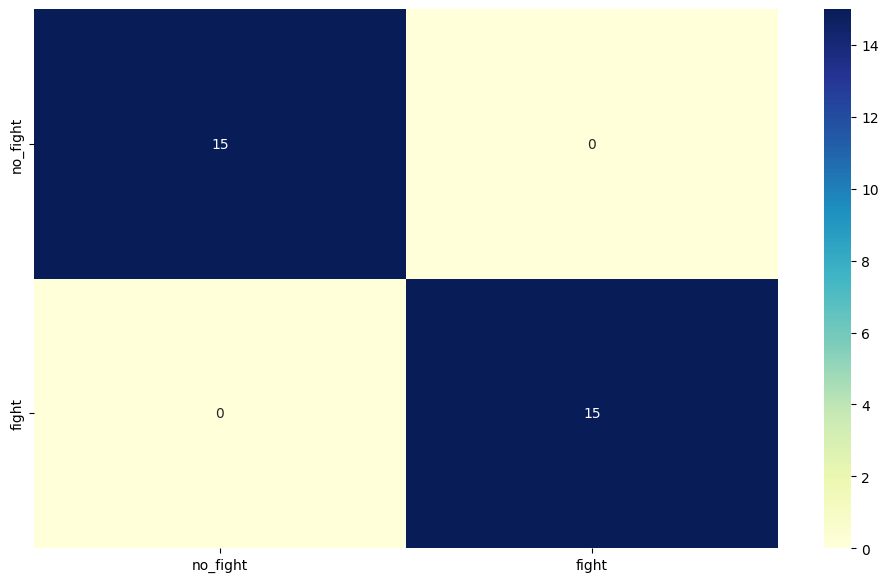

In [52]:
# constant for classes
classes = ('no_fight', 'fight')

# Build confusion matrix
cf_matrix = confusion_matrix(lbs, preds_lbs)
df_cm = pd.DataFrame(cf_matrix,
                     index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, cmap="YlGnBu", annot=True)
plt.savefig('output.png')

In [53]:
print('Classification Report')
print(classification_report(lbs, preds_lbs, target_names=['no-violance','violance']))

Classification Report
              precision    recall  f1-score   support

 no-violance       1.00      1.00      1.00        15
    violance       1.00      1.00      1.00        15

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [54]:
import pandas as pd
df = pd.DataFrame(classification_report(lbs, preds_lbs, target_names=['no-violance','violance'], output_dict=True)).transpose()
df

,precision,recall,f1-score,support
no-violance,1.0,1.0,1.0,15.0
violance,1.0,1.0,1.0,15.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,30.0
weighted avg,1.0,1.0,1.0,30.0
